<a href="https://colab.research.google.com/github/Narcissist1/Cellari-Deeplearning-Course/blob/codelab/CellariTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import glob
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from segnet import SegNet
from unet import UNet
from torch.optim import lr_scheduler

In [0]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

def accuracy(ys, ts):
    ys[ys>0] = 1
    ys[ys<0] = 0
    correct = (ys == ts).sum().item()
    accs = (correct / ts.size)
    return accs


In [84]:
if use_cuda:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
if use_cuda:
    path_to_images = '/content/drive/My Drive/train/raw_images'
    path_to_annotations = '/content/drive/My Drive/train/annotations_white'
else:
    path_to_images = 'train/raw_images'
    path_to_annotations = 'train/annotations_white'

transform_pipe = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    torchvision.transforms.RandomCrop(size=(128, 128)),
    
    torchvision.transforms.RandomHorizontalFlip(0.5),
    
    torchvision.transforms.RandomVerticalFlip(0.5),
    
    torchvision.transforms.ToTensor()
])

transform_observe = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    torchvision.transforms.ToTensor()
])


# Unet resize transform
transform_resize = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), # Convert np array to PILImage
    
    torchvision.transforms.Resize((212, 212)),
    
    torchvision.transforms.ToTensor()
])

data_norm = torchvision.transforms.Normalize(mean=[0.78092086, 0.5018261, 0.7803567],
                                 std=[0.16727196, 0.24176046, 0.13103652])


class CustomDataset(Dataset):
    
    def __init__(self, img_list, anno_list, num_of_classes=2, transform=None):
        
        self.img_list = img_list
        self.anno_list = anno_list
        self.num_of_classes = num_of_classes
        self.transform = transform
        
    def __getitem__(self, img_id):
        
        image = Image.open(img_list[img_id])
        img = np.array(image)
        anno = np.array(Image.open(self.anno_list[img_id]).convert("L"))

        seed = np.random.randint(2147483647)
        random.seed(seed)
        if self.transform:
            img = self.transform(img)
            img = data_norm(img)
            random.seed(seed)
            anno = self.transform(anno)
            # anno = transform_resize(anno)     # unet resize

        anno[anno>0] = 1
        # anno_reshaped = np.zeros((self.num_of_classes, anno.shape[1], anno.shape[2]))
        # for i in range(self.num_of_classes):
        #     anno_reshaped[i, :, :][anno[0] == i] = 1

        sample = {"image": img, "annotation": anno}
        return sample
    
    
    def __len__(self):
        return len(self.img_list)

img_list = glob.glob(path_to_images + os.sep + "*.bmp")
img_list = sorted(img_list)
anno_list = glob.glob(path_to_annotations + os.sep + "*.bmp")
anno_list = sorted(anno_list)
dataset_train = CustomDataset(img_list, anno_list, 2, transform=transform_pipe)
dataset_observe = CustomDataset(img_list, anno_list, 2, transform=transform_observe)

In [0]:
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 50,
    shuffle=True
)

dataloader_observe = torch.utils.data.DataLoader(
    dataset_observe,
    batch_size = 1,
    shuffle=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(50, 3, 128, 128)


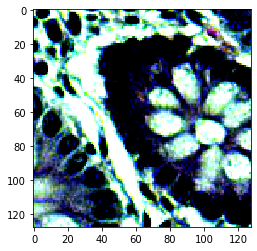

torch.Size([50, 1, 128, 128])


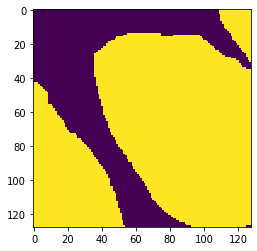

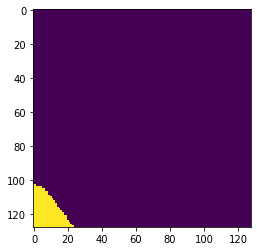

In [87]:
data = [batch_data for batch_data in dataloader_train]
batch_data = data[0]
fig_img = plt.figure()
print(batch_data['image'].numpy().shape)
plt.imshow(batch_data['image'][0].permute(1, 2, 0).numpy())
plt.show()
print(batch_data['annotation'].shape)
batch_data['annotation'] = batch_data['annotation']
plt.imshow(batch_data['annotation'][0][0])
fig_img.suptitle('image')
plt.show()
plt.imshow(batch_data['annotation'][1][0])
plt.show()

In [0]:
net = SegNet(1, n_init_features=3) # input channels, output channels
# net = UNet(1, n_init_features=3)
if use_cuda:
    net.cuda()

In [0]:
LEARNING_RATE = 0.001
criterion = nn.BCEWithLogitsLoss() 

# optimizer = optim.SGD(net.parameters(), LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), 8e-5, (0.9, 0.999),  eps=1e-08, weight_decay=1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[200], gamma=0.1)


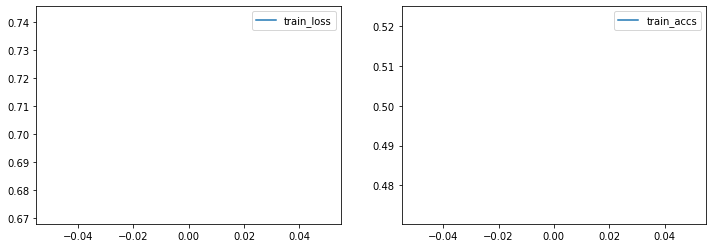

Train, it: 0 loss: 0.71 accs: 0.50


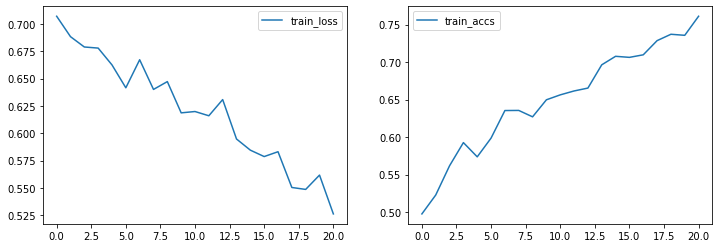

Train, it: 20 loss: 0.53 accs: 0.76


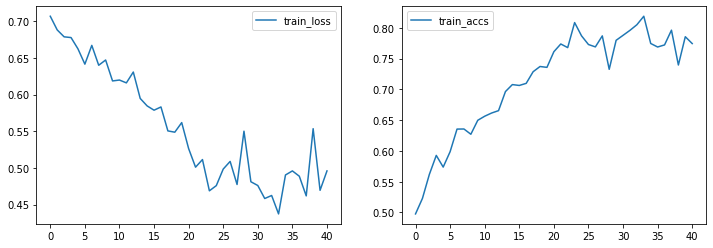

Train, it: 40 loss: 0.50 accs: 0.77


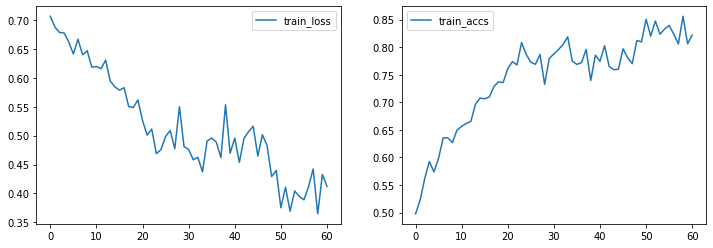

Train, it: 60 loss: 0.41 accs: 0.82


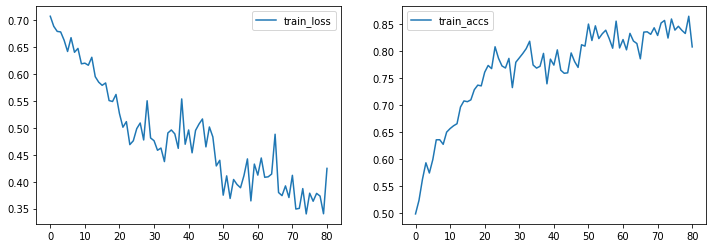

Train, it: 80 loss: 0.42 accs: 0.81


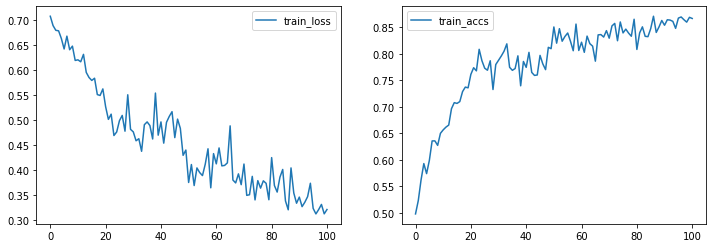

Train, it: 100 loss: 0.32 accs: 0.87


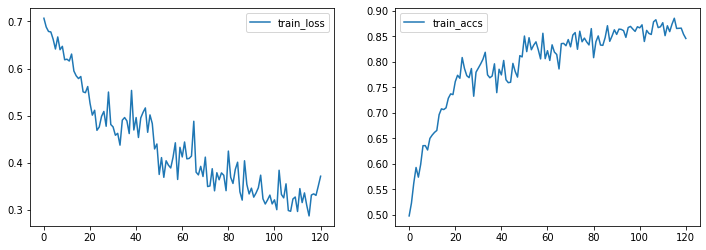

Train, it: 120 loss: 0.37 accs: 0.85


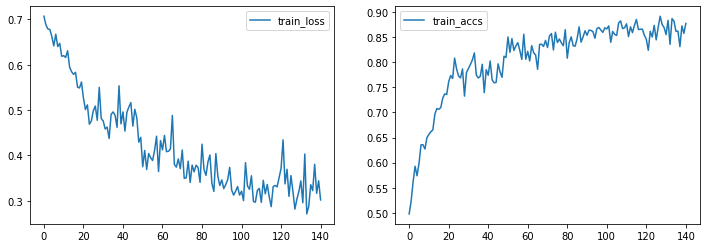

Train, it: 140 loss: 0.30 accs: 0.88


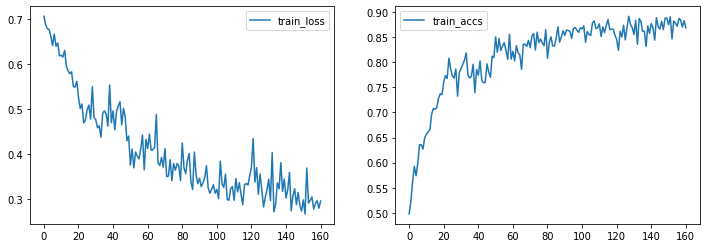

Train, it: 160 loss: 0.29 accs: 0.87


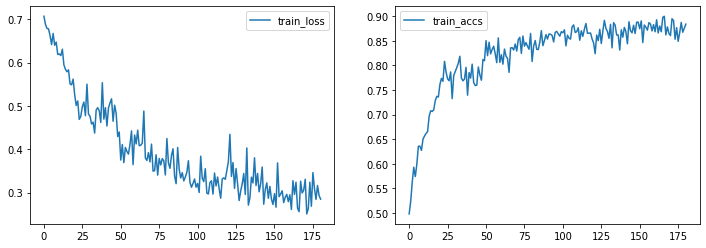

Train, it: 180 loss: 0.28 accs: 0.88


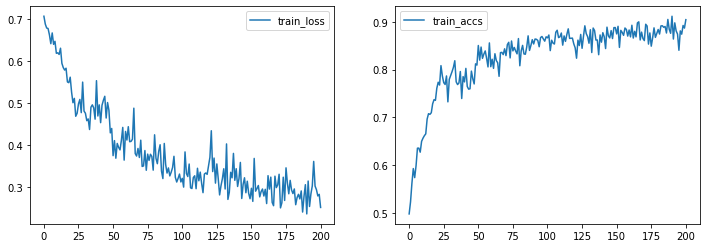

Train, it: 200 loss: 0.25 accs: 0.90


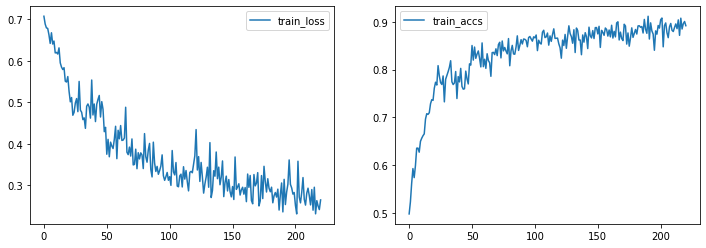

Train, it: 220 loss: 0.27 accs: 0.89


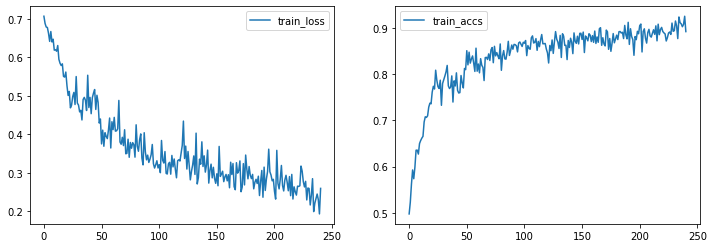

Train, it: 240 loss: 0.26 accs: 0.89


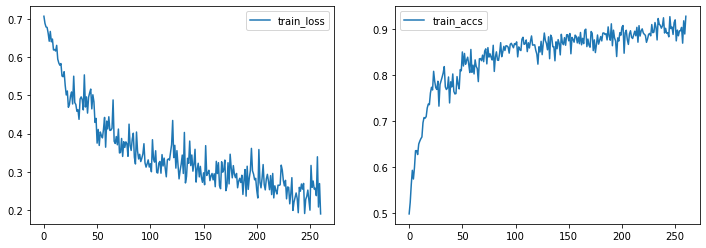

Train, it: 260 loss: 0.19 accs: 0.93


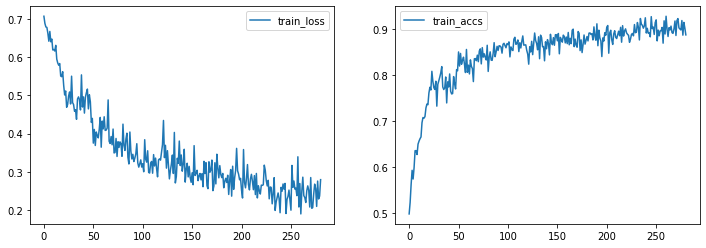

Train, it: 280 loss: 0.28 accs: 0.89


In [90]:
max_iter = 300
log_every = 100
eval_every = 100

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Train network
net.train()
for i in range(max_iter):
    train_iter.append(i)
    cur_loss = 0
    cur_accs = 0
    batch_iter = 0
    for j, batch_train in enumerate(dataloader_train):
        # Train
        inputs = get_variable(Variable(batch_train['image']))
        anno = get_variable(Variable(batch_train['annotation']))
        output = net(inputs)
        batch_loss = criterion(output, anno)

        cur_accs += float(accuracy(get_numpy(output), get_numpy(anno)))
        cur_loss += float(get_numpy(batch_loss))
        batch_iter = j + 1
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    # scheduler.step()
    cur_loss /= batch_iter
    cur_accs /= batch_iter
    train_accs.append(cur_accs)
    train_loss.append(cur_loss)
    if i % 20 == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.legend()
        plt.show()
        print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))


input shape: torch.Size([1, 3, 522, 775])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


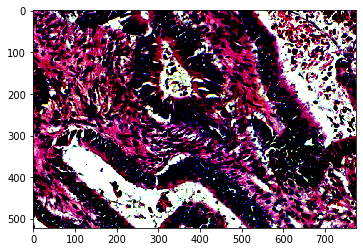

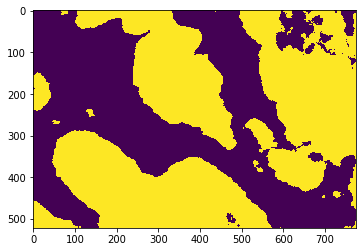

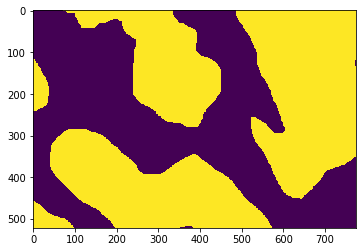

In [91]:
for batch_data in dataloader_observe:
    fig_img = plt.figure()
    inputs = get_variable(Variable(batch_data['image']))
    anno = batch_data['annotation']
    output = net(inputs)
    print('input shape:', inputs.shape)
    plt.imshow(get_numpy(inputs[0].permute(1, 2, 0)))
    plt.show()
    fig_img.suptitle('image')
    out1 = get_numpy(output[0][0])
    out1[out1>0] = 1
    out1[out1<0] = 0
    plt.imshow(out1)
    # plt.show()
    # out2 = get_numpy(output[0][1])
    # out2[out2>0] = 0
    # out2[out2<0] = 1
    # plt.imshow(out2)
    plt.show()
    plt.imshow(anno[0][0])
    plt.show()
    break

In [92]:
anno = get_variable(Variable(anno))
loss = criterion(output, anno)
accs = accuracy(get_numpy(output), get_numpy(anno))
print("loss: {:.2f} accs: {:.2f}".format(loss, accs))

loss: 0.21 accs: 0.91
